<a href="https://colab.research.google.com/github/hisham32/DhakaAI-yolov5/blob/master/DhakaAI_YOLOv5_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://dhaka-ai.com/static/images/logo.png" align="center"/>

In this notebook I am going to show you how you can process the original dataset given for the [Dhaka.ai Challenge 2020](https://dhaka-ai.com/index) to train and generate submission files from the Starter Code given on the host site. As this is the first Machine Learning Comptition in Bangladesh, it will be a bit tough for the undergraduate students to catch up with bits and pieces of data pre processing in this object detection and localization competition. My notebook is for those who are willing to participate but don't have a deeper understanding of data pre-processing. Once you are able to run the basic train and submission, you can gradually study the starter code and tweak it to improve. Good Luck !


<br>
<br>

### Notebook Author:<br>

Md. Redwan Karim Sony<br>
Lecturer, Dept. of CSE,<br>
Islamic University of Technology [(IUT)](http://www.iutoic-dhaka.edu/) <br>
Email: [redwankarim@iut-dhaka.edu](mailto:redwankarim@iut-dhaka.edu)<br>
Kaggle: [@redwankarimsony](https://kaggle.com/redwankarimsony)

<br>
<br>

<h1>Table of Content:</h1>

1. [Data Download](#1)
2. [Data Cleaning](#2)
3. [Convert .xml to .txt](#3)
4. [Resizing all the Images](#4)
5. [Train and Validation Split](#5)
6. [Creating Metadata:](#6)
7. [Saving the Processed Dataset](#7)

<a id="1"></a>
##1. Data Download: 
First of all you need to download the original data hosted in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/POREXF) repository. For simplicity I just downloaded it and put it on my google drive. You can simply download the data and unzip it into an usable form just by running the follwoing cell of code.  

In [ ]:
# Connecting colab to google drive for uploading data to colab 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output
import os, glob


# Downloading the dataset
!gdown --id 1GIiqqmqEPSiGBb1MU1kIZG4q7BOIzqik 
!unzip traffic-dataset.zip; rm traffic-dataset.zip;
clear_output()

# There was .rar file inside .zip file. So we unzip them again !
!unrar x train.rar
!unrar x test1.rar
clear_output()

# Removing rar files that we no longer need. 
!rm train.rar
!rm test1.rar

# Removing unnecessary demo data folder from workspace.
!rm -r sample_data

# Renaming raw data folder to remove space. Trust me, it makes life a lot easier :D 
%mv 'Final Train Dataset' train_data_raw


<a id="2"></a>
## 2. Data Cleaning:
At the time of initial coding, I found some problem with three of the images. They had two categories of problem. 
1. Train image files <font color="red">`Pias (359).PNG` </font> and <font color="red">`Pias (360).PNG` </font> are actually  `JPEG` files but somehow they are named with extention `.PNG`. So the height and width attribute in the corresponding xml labels are 0 as automatic label generator could not read the image properly. 

2. One of the label files <font color="red"> `231.xml` </font> is actually a `.txt` format label but labeled as `.xml` file. However for the inconsistency of the label index in that file, we will simply drop label and image together. 


To avoid the problem, simply we will remove these three problematic files and process rest of them. The follwoing code cell will remove them and their label file.


In [ ]:
corrupt_files = ['231.jpg', '231.xml', 'Pias (359).PNG','Pias (359).xml', 'Pias (360).PNG', 'Pias (360).xml']

%cd /content/train_data_raw/

for file in corrupt_files:
    file_path = os.path.join('/content/train_data_raw/', file)  
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f'{file} is removed successfully')
    else:
        print(f'{file} is already deleted')

%cd /content/

/content/train_data_raw
231.jpg is removed successfully
231.xml is removed successfully
Pias (359).PNG is removed successfully
Pias (359).xml is removed successfully
Pias (360).PNG is removed successfully
Pias (360).xml is removed successfully
/content


<a id="3"></a>
## 3. Convert .xml  to .txt
Now in the follwoing code cell, we define a function <font color ="blue"> `convert_xml2yolo()` </font> which will covert `.xml` format label file into `.txt` format file with the same name. 


Here is the required format of labels for YoLo V3: (for one image one text file)
* One row per object
* Each row is `class index` `x_center` `y_center` `width` `height` format describing a single bounding box. 
* Box coordinates must be in normalized `xywh format` from [0 - 1]. If your boxes are in pixels, divide `x_center` and `width` by `image_width`, and `y_center` and `height` by `image_height`.
* Class numbers are zero-indexed (start from 0).


The annotating process generates a text file for each image, contains the object class index and coordination for each object in it, as this format `(object-id) (x_centre) (y_centre) (width) (height)` in each line for each object. Coordinations values `(x_center, y_center, width, and height)` are relative to the width and the height of the image. Below are the formula for conversion. 

* $x\_center = \frac{(x\_min + x\_max) }{2(image\_height)}$
* $y\_center = \frac{(y\_min + y\_max) }{2(image\_width)}$
* $height = \frac{(x\_max - x\_min)}{(image\_height)}$
* $width = \frac{(y\_max - y\_min)}{(image\_width)}$

Where the image is denoted like: 

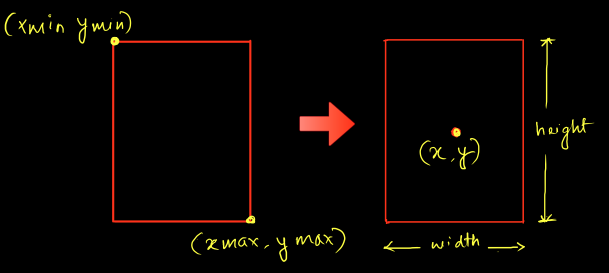

In [ ]:
"""
Thanks to @bjornstenger for his excellent code for converting the code from XML format to .txt format
here is the original link of this cell of code.
Original Link: https://github.com/bjornstenger/xml2yolo/blob/master/convert.py 
"""

from xml.dom import minidom

# Remember these number assigned. These are the label indexes which will be used in the training process.
# Feel free to unfold to see what's inside 
lut={"ambulance": 0,
     "auto rickshaw": 1,
     "bicycle": 2,
     "bus": 3,
     "car": 4,
     "garbagevan": 5,
     "human hauler": 6,
     "minibus": 7,
     "minivan": 8,
     "motorbike": 9,
     "pickup": 10,
     "army vehicle": 11,
     "policecar": 12,
     "rickshaw": 13,
     "scooter": 14,
     "suv": 15,
     "taxi": 16,
     "three wheelers (CNG)": 17,
     "truck": 18,
     "van": 19,
     "wheelbarrow": 20
     }

label_count ={}

print(f'Object Names: {list(lut.keys())}' )

def convert_coordinates(size, box):
    """
    This function converts the coordinates. 
    box: (xmin, ymin, xmax, ymax)
    size: (width, height)

    returns a touple where (x, y, height, width) of the boundary box
    """
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def convert_xml2yolo(filelist, lut ):
    """
    filelist: list of .xml file paths to convert to .txt file
    lut: a dictionary containing class_name to class_index mapping
    """
    for fname in filelist:
        xmldoc = minidom.parse(fname)
        fname_out = (fname[:-4]+'.txt')

        with open(fname_out, "w") as f:
            # print(f'processing{fname}')

            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)

            for item in itemlist:
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data
                if classid in lut:
                    label_str = str(lut[classid])
                else:
                    label_str = "-1"
                    print ("warning: label '%s' not in look-up table for file '%s'" % classid, fname )
                # get bbox coordinates
                xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = convert_coordinates((width,height), b)
                #print(bb)

                label_count[classid] = label_count.get(classid, 0) + 1

                f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
        # print ("wrote %s" % fname_out)


Object Names: ['ambulance', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'army vehicle', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow']


Now Let us create the path list of the `.xml` files to convert them to `.txt` files. 

In [ ]:
# Reading Image file paths
formats = ['jpg', 'jpeg', 'JPG', 'png']
image_file_list = []
for format in formats:
    image_file_list.extend(glob.glob(f'/content/train_data_raw/*.{format}'))

# Reading XML label file paths
label_file_list_xml = glob.glob('/content/train_data_raw/*.xml')

print(f'Image files found: {len(image_file_list)} \nLabel files found: { len(label_file_list_xml)}')

Image files found: 3000 
Label files found: 3000


In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2843
Number of annotations in the folder
ls: cannot access 'train_data_raw/*.txt': No such file or directory
0


In [ ]:
# Converting .xml file to .txt file
convert_xml2yolo(label_file_list_xml, lut)
label_file_list_txt = glob.glob('/content/train_data_raw/*.txt')
print(f'XML --> TXT files: {len(label_file_list_txt)}')

XML --> TXT files: 3000


In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2843
Number of annotations in the folder
3000


In [ ]:
label_count

{'ambulance': 70,
 'army vehicle': 43,
 'auto rickshaw': 372,
 'bicycle': 459,
 'bus': 3333,
 'car': 5476,
 'garbagevan': 3,
 'human hauler': 169,
 'minibus': 95,
 'minivan': 934,
 'motorbike': 2284,
 'pickup': 1225,
 'policecar': 32,
 'rickshaw': 3536,
 'scooter': 38,
 'suv': 859,
 'taxi': 60,
 'three wheelers (CNG)': 2989,
 'truck': 1492,
 'van': 756,
 'wheelbarrow': 119}

In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2843
Number of annotations in the folder
3000


## Data Visualization: 
Let us have a look at the existance of the labels in the dataset. 

In [ ]:
'''
import pandas as pd
import plotly.express as px

# DataFrame Generation
df = pd.DataFrame({'labels': label_count.keys(), 'count': label_count.values()})
df.columns = ['labels', 'count']
df.sort_values(['count'], ascending = False, inplace =True)
df.head()

# Plotting
fig = px.bar(df, x="labels", y='count',  color="count",
    orientation='v', 
    title='Frequency of the Labels in Dhaka.ai-2020 Challenge', 
    color_continuous_scale=px.colors.sequential.Viridis_r
)
fig.update_layout(title_x=0.5, xaxis_title = 'Labels', yaxis_title = 'Label Count')
fig.update_xaxes(tickangle=60)
fig.show()
'''

'\nimport pandas as pd\nimport plotly.express as px\n\n# DataFrame Generation\ndf = pd.DataFrame({\'labels\': label_count.keys(), \'count\': label_count.values()})\ndf.columns = [\'labels\', \'count\']\ndf.sort_values([\'count\'], ascending = False, inplace =True)\ndf.head()\n\n# Plotting\nfig = px.bar(df, x="labels", y=\'count\',  color="count",\n    orientation=\'v\', \n    title=\'Frequency of the Labels in Dhaka.ai-2020 Challenge\', \n    color_continuous_scale=px.colors.sequential.Viridis_r\n)\nfig.update_layout(title_x=0.5, xaxis_title = \'Labels\', yaxis_title = \'Label Count\')\nfig.update_xaxes(tickangle=60)\nfig.show()\n'

In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.png | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.JPG | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.jpeg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2843
Number of annotations in the folder
12
Number of annotations in the folder
143
Number of annotations in the folder
2
Number of annotations in the folder
3000


<a id="4"></a>
## 4. Resizing all the Images (Optional)
If you observe carefully, you will see that images have different sizes. They are not uniform. The following code segment visualizes that nicely.  <font color="red">It seems that 3000 images has 430 different resolutins. </font> Here the follwoing segment of code shows that we have some high resolution images which we have to downsampled to $(1024x1024)$ and some images which have lower resolution than $(1024x1024)$ should be upsampled. 

😃😃😃 <font color="green"> Since yolo v3 uses relative bounding box parameters, we changing the aspect ration will have no effect on the bounding box placement. So we dont have to change the labels after we resize the images.  </font>

In [ ]:
from PIL import Image
img_sizes = {}

for fname in image_file_list:
    img = Image.open(fname)
    img_sizes[img.size] = img_sizes.get(img.size, 0) +1 
img_sizes

{(352, 399): 1,
 (352, 401): 1,
 (352, 404): 1,
 (352, 405): 1,
 (352, 421): 1,
 (352, 426): 1,
 (352, 429): 1,
 (352, 432): 1,
 (352, 435): 1,
 (352, 436): 2,
 (352, 437): 1,
 (352, 438): 1,
 (352, 439): 2,
 (352, 443): 1,
 (352, 444): 1,
 (352, 445): 1,
 (352, 448): 1,
 (352, 454): 1,
 (352, 456): 1,
 (352, 458): 1,
 (352, 460): 1,
 (352, 461): 1,
 (352, 462): 1,
 (352, 467): 1,
 (352, 469): 2,
 (352, 472): 1,
 (352, 476): 1,
 (352, 478): 1,
 (352, 479): 3,
 (352, 482): 1,
 (352, 486): 1,
 (352, 488): 1,
 (352, 490): 1,
 (352, 491): 1,
 (352, 492): 1,
 (352, 493): 1,
 (352, 496): 1,
 (352, 498): 2,
 (352, 502): 1,
 (352, 506): 2,
 (352, 507): 1,
 (352, 509): 1,
 (352, 511): 2,
 (352, 512): 1,
 (352, 515): 1,
 (352, 517): 1,
 (352, 524): 1,
 (352, 526): 1,
 (352, 527): 1,
 (352, 537): 1,
 (352, 543): 2,
 (352, 545): 1,
 (352, 547): 1,
 (352, 586): 1,
 (407, 539): 1,
 (431, 576): 1,
 (451, 587): 1,
 (490, 654): 1,
 (491, 654): 1,
 (491, 656): 1,
 (492, 655): 1,
 (530, 667): 1,
 (540, 3

In [ ]:
def resize_images(file_list, width = 1024, height = 1024, overwrite = True, save_dir = ''):
    total_files = len(file_list)
    idx = 1
    for path in file_list:
        img = Image.open(path)
        img_resized = img.resize((width, height))
        if overwrite:
            img_resized.save(path)
            filename = path.split('/')[-1] 
            print(f"{idx}/{total_files}: {filename} {img.size}--> ({width}x{height})")
        else:
            filename = path.split('/')[-1]
            img_resized.save(save_dir + filename)
            print(f'{filename} saved to {save_dir}')
        idx +=1
    clear_output()

In [ ]:
resize_images(image_file_list , overwrite= True)

We don't have to resize the test images because they are already resized to our desired format. 

<a id="5"></a>
## 5. Train and Validation Split
For training the model and evaluating at the same time, we will split the whole training dataset into a train and validation set. We will be using $80-20$ dividion rule for the train and validation split. 

In [ ]:
import random
random.seed(401)

#randomply selecting the index of the files
valid_set_index = random.sample(range(len(image_file_list)), 500)
len(set(image_file_list)), len(set(label_file_list_txt)), len(valid_set_index)

image_file_list = sorted(image_file_list)
label_file_list_txt = sorted(label_file_list_txt)

# sanity check of the image files and labels being in the same order
print('Checking files concurrency')
print(image_file_list[:5])
print(label_file_list_txt[:5])

# code to separate train and validation set
valid_selected_images = []
valid_selected_labels = []

for index in valid_set_index: 
    valid_selected_images.append(image_file_list[index])
    valid_selected_labels.append(label_file_list_txt[index])


print('\n\nChecking files concurrency in validation set')
print(valid_selected_images[:5])
print(valid_selected_labels[:5])

Checking files concurrency
['/content/train_data_raw/01.jpg', '/content/train_data_raw/02.jpg', '/content/train_data_raw/03.jpg', '/content/train_data_raw/04.jpg', '/content/train_data_raw/05.jpg']
['/content/train_data_raw/01.txt', '/content/train_data_raw/02.txt', '/content/train_data_raw/03.txt', '/content/train_data_raw/04.txt', '/content/train_data_raw/05.txt']


Checking files concurrency in validation set
['/content/train_data_raw/Numan_(143).jpg', '/content/train_data_raw/Dipto_ 191.jpg', '/content/train_data_raw/Navid_635.JPG', '/content/train_data_raw/Dipto_852.jpg', '/content/train_data_raw/Numan_(44).jpg']
['/content/train_data_raw/Numan_(143).txt', '/content/train_data_raw/Dipto_ 191.txt', '/content/train_data_raw/Navid_635.txt', '/content/train_data_raw/Dipto_852.txt', '/content/train_data_raw/Numan_(44).txt']


In [ ]:
import shutil

# Creating validation directory
valid_dir = '/content/valid/'

if os.path.exists(valid_dir):
    print(f'Directory {valid_dir} already exists !')
else: 
    os.makedirs(valid_dir)
    print(f"Directory {valid_dir} is created successfully!") 


for idx in range(len(valid_selected_images)):
    # moving image files
    mypath = valid_selected_images[idx]
    if os.path.exists(mypath):
        filename = mypath.split('/')[-1]
        shutil.move(mypath , valid_dir + filename)
    else:
        print(f'{mypath} not found')
        
    # moving label files
    mypath = valid_selected_labels[idx]
    if os.path.exists(mypath):
        filename = mypath.split('/')[-1]
        shutil.move(mypath , valid_dir + filename)
    else:
        print(f'{mypath} not found')

Directory /content/valid/ is created successfully!


## **Augmentation using CLoDSA (Augmentation)**

### Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [ ]:
!pip install clodsa

     |████████████████████████████████| 5.7MB 6.9MB/s 
     |████████████████████████████████| 276kB 42.5MB/s 
  Created wheel for clodsa: filename=clodsa-1.2.42-py2.py3-none-any.whl size=72142 sha256=70a7452ca6dee11ceaebcad9cd2f679b16e9eecd09459b5f89e4546e103bb5b9
  Stored in directory: /root/.cache/pip/wheels/98/7c/f5/4caa95c8cf6a4ed959de7133a5a623ce0c9c4d134e57431204
  Created wheel for commentjson: filename=commentjson-0.9.0-cp36-none-any.whl size=12087 sha256=dce599114a7b5041151208b37070d3adaf3e3360d0803fd74debb0db30dc9d69
  Stored in directory: /root/.cache/pip/wheels/0d/18/46/8da734185b844fc754de60da2c162fc15f7acdacfd4621144e
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62514 sha256=d94e690fcb16888a170303f59dad443bdf0d18e206f3884c532dd7adeb5c0f77
  Stored in directory: /root/.cache/pip/wheels/01/a2/30/ebae6ffa73cf3aa1c972a24d4c78388afd910f91e43bf554aa
Successfully built clodsa commentjson lark-parser


### Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA. We also load some libraries to show the results.

In [ ]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

In [ ]:
os.mkdir('xml')

In [ ]:
import shutil

directory = '/content/train_data_raw/'
for filename in os.listdir(directory):
    if filename.endswith(".xml"):
        shutil.move('/content/train_data_raw/'+ filename, '/content/xml/' + filename)

## **Replacing png with jpg**

In [ ]:
!pip install image_to_numpy

  Created wheel for image-to-numpy: filename=image_to_numpy-1.0.0-cp36-none-any.whl size=3474 sha256=acc090cad4ac9f692049edb8c24945f17268b5bc6bc5f479b1e0ea8b3f0362d6
  Stored in directory: /root/.cache/pip/wheels/ee/f6/32/7d71a861b570d0faa8be3a04265809435f1aee4620ff4bdea1
Successfully built image-to-numpy


In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
directory = 'train_data_raw'
print(os.path.exists(directory))
for filename in os.listdir(directory):
    if filename.endswith(".png") or filename.endswith(".PNG") or filename.endswith(".jpeg") or filename.endswith(".JPEG"): 
      img = os.path.join(directory, filename)
      imagePath = img
      img = cv2.imread(img)
      img_name = directory+'/'+filename.split('.')[0] + '.jpg'
      print(img_name)
      # Save .jpg image
      cv2.imwrite(img_name, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
      os.remove(imagePath)
    else:
      continue

True
train_data_raw/193.jpg
train_data_raw/202.jpg
train_data_raw/200.jpg
train_data_raw/203.jpg
train_data_raw/204.jpg
train_data_raw/194.jpg
train_data_raw/197.jpg
train_data_raw/199.jpg
train_data_raw/196.jpg
train_data_raw/65.jpg


In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2387
Number of annotations in the folder
2500


In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.png | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.JPG | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.jpeg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2387
Number of annotations in the folder
ls: cannot access 'train_data_raw/*.png': No such file or directory
0
Number of annotations in the folder
113
Number of annotations in the folder
ls: cannot access 'train_data_raw/*.jpeg': No such file or directory
0
Number of annotations in the folder
2500


### Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a detection problem

In [ ]:
PROBLEM = "detection"

_The annotation mode_. We use the YOLO format. 

In [ ]:
ANNOTATION_MODE = "yolo"

_The input path_. The input path containing the images. 

In [ ]:
INPUT_PATH = "train_data_raw/"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [ ]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images.  

In [ ]:
OUTPUT_MODE = "yolo"
OUTPUT_PATH= "train_data_raw_1"

Using the above information, we can create our augmentor object. 

In [ ]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

### Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



Just for showing the results of applying data augmentation in an object detection problem, we define a function to read the annotations and another one to show them. This funcionality is not necessary when using CLODSA since it is already implemented in there. 

In [ ]:
def boxesFromYOLO(imagePath,labelPath):
    image = cv2.imread(imagePath)
    (hI, wI) = image.shape[:2]
    lines = [line.rstrip('\n') for line in open(labelPath)]
    #if(len(objects)<1):
    #    raise Exception("The xml should contain at least one object")
    boxes = []
    if lines != ['']:
        for line in lines:
            components = line.split(" ")
            category = components[0]
            x  = int(float(components[1])*wI - float(components[3])*wI/2)
            y = int(float(components[2])*hI - float(components[4])*hI/2)
            h = int(float(components[4])*hI)
            w = int(float(components[3])*wI)
            boxes.append((category, (x, y, w, h)))
    return (image,boxes)

In [ ]:
categoriesColors = {11: (255,0,0),14:(0,0,255)}

def showBoxes(image,boxes):
    cloneImg = image.copy()
    for box in boxes:
        if(len(box)==2):
            (category, (x, y, w, h))=box
        else:
            (category, (x, y, w, h),_)=box
        if int(category) in categoriesColors.keys():
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),categoriesColors[int(category)],5)
        else:
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(0,255,0),5)
    plt.imshow(cloneImg[:,:,::-1])
    

Now, we show the annotation of the image.

First of all, we must define a transformer generator.

In [ ]:
transformer = transformerGenerator(PROBLEM)

#### Rotation:

In [ ]:
rotate10 = createTechnique("rotate", {"angle" :10})
augmentor.addTransformer(transformer(rotate10))

#### Blurring

In [ ]:
Blurring5 = createTechnique("blurring", {"ksize" : 5})
augmentor.addTransformer(transformer(Blurring5))

#### Gaussian Noise

In [ ]:
gaussNoise1025 = createTechnique("gaussian_noise", {"mean" : 10,"sigma":25})
augmentor.addTransformer(transformer(gaussNoise1025))

#### Shearing

In [ ]:
Shearing1 = createTechnique("shearing", {"a":0.1})
augmentor.addTransformer(transformer(Shearing1))

### Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw/*.txt | wc -l

Number of images in the folder
2387
Number of annotations in the folder
2500


In [ ]:
augmentor.applyAugmentation()

Finally, we can check the amount of images in the output folder.

In [ ]:
print("Number of images in the folder")
!ls -1 train_data_raw_1/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 train_data_raw_1/*.txt | wc -l

Number of images in the folder
9548
Number of annotations in the folder
10000


In [ ]:
import shutil

directory = '/content/train_data_raw_1/'
for filename in os.listdir(directory):
    shutil.move('/content/train_data_raw_1/'+ filename, '/content/train_data_raw/' + filename)

Now the remaining images in the `train_data_raw` are actually the train directory. We will rename it to `train`

In [ ]:
!mv train_data_raw train  

<a id="6"></a>
## 6. Creating Metadata:
The strter code has some files as metadata. We need to produce contents for them. We have to produce the follwoing files. 
* `train.txt` : A text file containing full paths of all the training image files. 
* `valid.txt` : A text file containing full paths of all the validation image files
* `test.txt` :  A text file containing full paths of all the test image files
* `traffic.names`: A text file containing all the traffic label names line by line
* `traffic.data`: Its a confguration file that stores the number of classes, and the location of train.txt and valid.txt for training purpose

In [ ]:
def lookup_image_file_paths(formats, dir):
    """
    This function takes a specified set of formats and directory address to list all the filepaths
    of the desired format in that directory
    """
    filepaths = []
    for format in formats:
        filepaths.extend(glob.glob(f'{dir}*.{format}'))
    return filepaths

def make_txt_file(formats, dir):
    """
    Formats the file names to write in the desired txt file
    """
    filepaths = lookup_image_file_paths(formats, dir)
    
    filenames = [x.split('/')[-1] for x in filepaths]
    txt_file_name = dir.split('/')[-2]

    print(f'{txt_file_name} : {len(filepaths)} images')
    with open(f'/content/metadata/{txt_file_name}.txt', 'w') as outfile:
        for filename in filenames:
            outfile.write(f'data/{txt_file_name}/'+filename+'\n')
        outfile.close()


In [ ]:
train_dir = '/content/train/'
valid_dir = '/content/valid/'
test_dir =  '/content/test/'
!mkdir metadata

# Making the .txt file containing list of images. 
make_txt_file(formats, dir = train_dir)
make_txt_file(formats, dir = test_dir)
make_txt_file(formats, dir = valid_dir)

# Writing the file traffic.names
object_labels = list(lut.keys())
with open('/content/metadata/traffic.names', 'w') as outfile:
    for label in object_labels:
        outfile.write(label + '\n')
    outfile.close()

# Writing the file traffic.data
data_config = f'classes=21\ntrain=train.txt\nvalid=valid.txt\nnames=traffic.names'
with open('/content/metadata/traffic.data', 'w') as outfile:
    outfile.write(data_config + '\n')
    outfile.close()

train : 12500 images
test : 500 images
valid : 500 images


<a id="7"></a>
## 7. Saving the Processed Dataset:
Now our dataset is ready for using with the starter code given at the host site. But before that we need to save the processed dataset in google drive so that we can later use it in the Starter Code. 

<font color='red'> Now mount your google drive here so that you can export the processed `dhaka-traffic-yolo-v3.zip` to your drive for later use </font> Or you can just download it and again re upload it to the Starter Notebook in Google Colab. 

In [ ]:
!zip -r dhaka-traffic-yolo-v3_seed_401_partial_aug_.zip train test valid metadata
clear_output()

In [ ]:
shutil.rmtree('test')
shutil.rmtree('train')
shutil.rmtree('valid')

In [ ]:
!cp dhaka-traffic-yolo-v3_seed_401_partial_aug_.zip '/content/drive/My Drive/Hisham Vaia/DhakaAI 2020/'

Now we are done with pre-processing the data and we are ready to put the whole dataset to the training of Yolo V3 in the Starter Code given on the host website. 

Thank you and good luck!





